# Проект по A/B-тестированию


## Описание

Задача — провести оценку результатов A/B-теста. В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

- Оцените корректность проведения теста
- Проанализируйте результаты теста

## Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

## Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

## Откроем и изучим общую информацию о данных

In [1]:
! gdown -- 1nnwvut4fwpwwQb8uX92Qx_2GlxlDrZdK
! gdown -- 1x6igMvlG7Ev_7K1XbGv31i1W8ceie1bw
! gdown -- 1zHpPW-7NcnazhY3FMBIjO4VqRLuZ2BVJ
! gdown -- 1v5NrEAJLTrDpp43wiB9h90Y48hl38Tdj

Downloading...
From: https://drive.google.com/uc?id=1nnwvut4fwpwwQb8uX92Qx_2GlxlDrZdK
To: /content/final_ab_events.csv
100% 22.3M/22.3M [00:00<00:00, 365MB/s]
Downloading...
From: https://drive.google.com/uc?id=1x6igMvlG7Ev_7K1XbGv31i1W8ceie1bw
To: /content/ab_project_marketing_events.csv
100% 879/879 [00:00<00:00, 1.77MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zHpPW-7NcnazhY3FMBIjO4VqRLuZ2BVJ
To: /content/final_ab_new_users.csv
100% 2.37M/2.37M [00:00<00:00, 234MB/s]
Downloading...
From: https://drive.google.com/uc?id=1v5NrEAJLTrDpp43wiB9h90Y48hl38Tdj
To: /content/final_ab_participants.csv
100% 716k/716k [00:00<00:00, 113MB/s]


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go
import numpy as np
import pylab 
import math as mth
from datetime import datetime, timedelta

from scipy import stats as st
import statsmodels.sandbox.stats.multicomp as multi_correction

pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_colwidth', None)

In [3]:
def open(df_google_csv, df_ya_csv):
    try:
        df = pd.read_csv(df_google_csv)
    except:
        df = pd.read_csv(df_ya_csv)
    display(df.info(), df.head(3))
    return df  
    

In [4]:
events = open('/content/final_ab_events.csv', 'https://code.s3.yandex.net/datasets/final_ab_events.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99


In [5]:
users = open('/content/final_ab_new_users.csv', 'https://code.s3.yandex.net/datasets/final_ab_new_users.csv') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC


In [6]:
participants = open('/content/final_ab_participants.csv', 'https://code.s3.yandex.net/datasets/final_ab_participants.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test


In [7]:
marketing = open('/content/ab_project_marketing_events.csv', 'https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19


Данные открылись без замечаний. В ряде столбцов нужно поменять типы.

## Выполним предобработку данных

In [8]:
users.isna().mean()

user_id      0.00
first_date   0.00
region       0.00
device       0.00
dtype: float64

In [9]:
users.duplicated().sum()

0

In [10]:
events.isna().mean()

user_id      0.00
event_dt     0.00
event_name   0.00
details      0.86
dtype: float64

In [11]:
events.duplicated().sum()

0

In [12]:
participants.isna().mean()

user_id   0.00
group     0.00
ab_test   0.00
dtype: float64

In [13]:
participants.duplicated().sum()

0

In [14]:
marketing.isna().mean()

name        0.00
regions     0.00
start_dt    0.00
finish_dt   0.00
dtype: float64

In [15]:
marketing.duplicated().sum()

0

In [16]:
users['first_date'] = pd.to_datetime(users['first_date'], format=('%Y-%m-%d'))

events['event_dt_date'] = pd.to_datetime(events['event_dt']).dt.date
events['event_dt_date'] = pd.to_datetime(events['event_dt_date'], format=('%Y-%m-%d'))

marketing['start_dt'] =  pd.to_datetime(marketing['start_dt'], format=('%Y-%m-%d'))
marketing['finish_dt'] =  pd.to_datetime(marketing['finish_dt'], format=('%Y-%m-%d'))

Проверили датафреймы на пропуски, явные дубликаты, поменяли тип в датах. Много пропусков в деталях событий. Они не повлияют на дальнейшее исследование.

## Оценим корректность проведения теста

### Проверим корректность всех пунктов технического задания

In [17]:
print('Всего в датасете участников', len(participants), 'строк')

Всего в датасете участников 18268 строк


In [18]:
print('В этих строках', participants['user_id'].nunique(), 'уникальных участников')

В этих строках 16666 уникальных участников


In [19]:
all_group = set(participants.query('ab_test == "recommender_system_test"')['user_id']) & set(participants.query('ab_test == "interface_eu_test"')['user_id']) 

f'Одинаковых пользователей для тестов recommender_system_test и interface_eu_test: {len(all_group)}'

'Одинаковых пользователей для тестов recommender_system_test и interface_eu_test: 1602'

In [20]:
participants = participants.drop_duplicates('user_id')

Удалили пересекающихся пользователей.

In [21]:
all_group = set(participants.query('ab_test == "recommender_system_test"')['user_id']) & set(participants.query('ab_test == "interface_eu_test"')['user_id']) 

f'Одинаковых пользователей для тестов recommender_system_test и interface_eu_test: {len(all_group)}'

'Одинаковых пользователей для тестов recommender_system_test и interface_eu_test: 0'

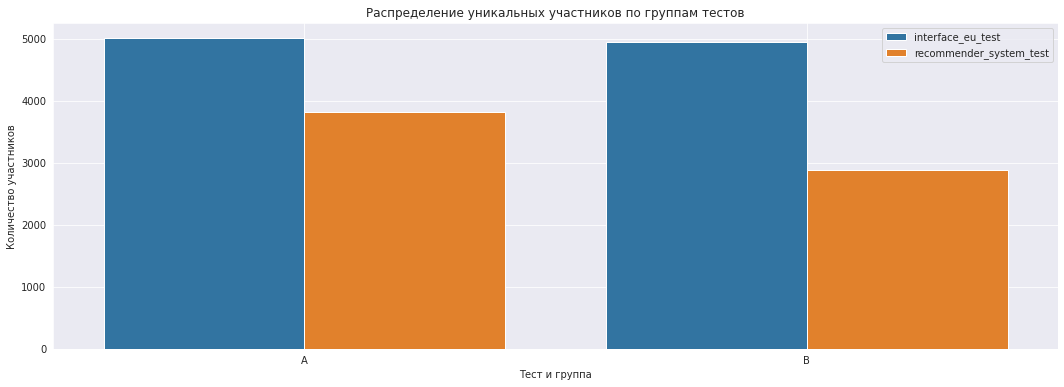

In [22]:
sns.set_style('dark')

plt.figure(figsize=(18, 6))

sns.barplot(x='group', y='user_id', data=participants.groupby(['ab_test', 'group'])['user_id'].nunique().reset_index(), hue='ab_test')

plt.title('Распределение уникальных участников по группам тестов')
plt.xlabel('Тест и группа')
plt.ylabel('Количество участников')
plt.legend(loc='upper right', fontsize=10)
plt.grid()

plt.show()

Группы смежного теста распределены поровну. В контрольной группе нашего теста `recommender_system_test` пользователей немного больше, чем в тестовой группе.

Сохраним пользователей смежного теста, чтобы исключить их смешивание с пользователями нашего теста в остальных датафреймах.

In [23]:
users_the_othert_test = participants[participants['ab_test'] != 'recommender_system_test']['user_id'].tolist()

In [24]:
participants.groupby(['ab_test', 'group'])['user_id'].count()

ab_test                  group
interface_eu_test        A        5012
                         B        4953
recommender_system_test  A        3824
                         B        2877
Name: user_id, dtype: int64

В датафрейме участники двух тестов. Удалим второй, чтобы гарантированно избавиться от пересечений по тестам.

In [25]:
participants= participants[participants['ab_test'] == 'recommender_system_test'].copy()

In [26]:
participants.groupby(['ab_test', 'group'])['user_id'].count()

ab_test                  group
recommender_system_test  A        3824
                         B        2877
Name: user_id, dtype: int64

Выборки распределены неравномерно. В контрольной группе на 1 тысячу участников больше, чем в тестовой.

Еще раз убедимся, что нет пересечений пользователей.

In [27]:
all_group = set(participants.query('group == "A"')['user_id']) & set(participants.query('group == "B"')['user_id']) 

f'Одинаковых пользователей для групп A и B: {len(all_group)}'

'Одинаковых пользователей для групп A и B: 0'

In [28]:
print('В тесте "recommender_system_test"', participants['user_id'].nunique(), 'уникальных пользователей')

В тесте "recommender_system_test" 6701 уникальных пользователей


Рассмотрим датафрейм с пользователями со всего мира.

Исследуем регионы.

In [29]:
total_users = users.copy()

total_users_by_regions = total_users['region'].value_counts()
total_users_by_regions

EU           46270
N.America     9155
CIS           3155
APAC          3153
Name: region, dtype: int64

Оставим только европейских пользователей, так как регион проведения теста - Европа.

In [30]:
users = users[users['region'] == 'EU'].copy()

Исследуем даты регистрации европейских пользователей. Для начала избавимся от пользователей из смежного теста, если такие есть.

In [31]:
before = users['user_id'].nunique()

In [32]:
users = users.query('user_id not in @users_the_othert_test').copy()

In [33]:
after = users['user_id'].nunique()

In [34]:
if before == after:
  print('Количество уникальных пользователей не изменилось -', after)
else:
  print('Количество уникальных пользователей уменьшилось. Было -', before, 'Стало -', after,\
        'Изменения -', round(((after / before * 100) - 100), 2), '%')

Количество уникальных пользователей уменьшилось. Было - 46270 Стало - 36305 Изменения - -21.54 %


In [35]:
users['first_date'].value_counts().reset_index().sort_values(by = 'index')

,index,first_date
2,2020-12-07,3337
8,2020-12-08,1900
14,2020-12-09,1258
9,2020-12-10,1888
13,2020-12-11,1415
5,2020-12-12,2290
3,2020-12-13,2773
1,2020-12-14,3356
10,2020-12-15,1797
15,2020-12-16,1258


Согласно ТЗ, в тесте участвуют пользователи, зарегистрировавшиеся не позднее 2020-12-21. Отсечем лишнее.

In [36]:
users = users[users['first_date'] <= '2020-12-21']

In [37]:
users['first_date'].value_counts().reset_index().sort_values(by = 'index')

,index,first_date
2,2020-12-07,3337
8,2020-12-08,1900
13,2020-12-09,1258
9,2020-12-10,1888
12,2020-12-11,1415
5,2020-12-12,2290
3,2020-12-13,2773
1,2020-12-14,3356
10,2020-12-15,1797
14,2020-12-16,1258


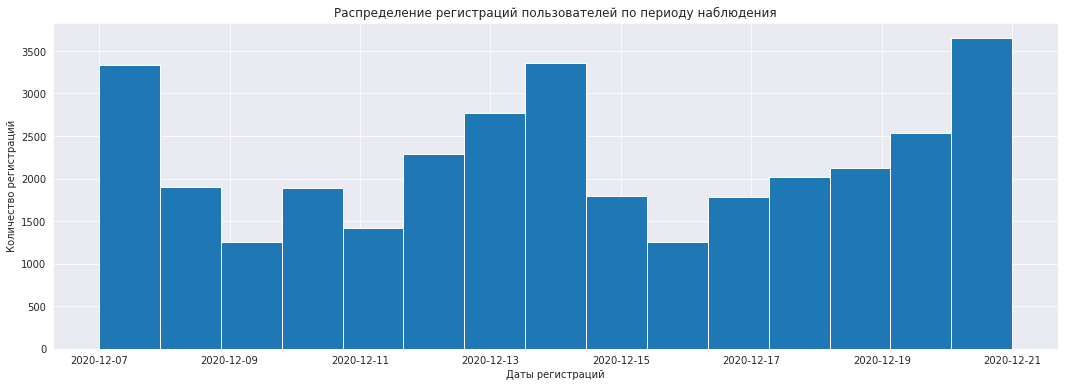

In [38]:
users['first_date'].hist(bins = 15, figsize=(18, 6))

plt.title('Распределение регистраций пользователей по периоду наблюдения')
plt.xlabel('Даты регистраций')
plt.ylabel('Количество регистраций');

Новые пользователи приходили каждый день. Пиковые значения наблюдаются в начале каждой недели проведения теста. Отметим, что эти даты - 7, 14, 21 декабря - понедельники.

In [39]:
print('На данном этапе в датафрейме с пользователями', users['user_id'].nunique(), 'уникальных пользователей из Европы')

На данном этапе в датафрейме с пользователями 33377 уникальных пользователей из Европы


Вспомним, сколько у нас уникальных участников теста.

In [40]:
participants['user_id'].nunique()

6701

Отфильтруем пользователей, оставим тех, кто является участниками теста.

In [41]:
test_participants = participants['user_id'].tolist()

In [42]:
users = users.query('user_id in @test_participants')

In [43]:
print('Изначально уникальных участников теста - ', participants['user_id'].nunique())
print('Уникальных участников после фильтрации по дате регистрации и региону - ', users['user_id'].nunique())
print('Количество уникальных участников уменьшилось на ', round(100 - (users['user_id'].nunique() / participants['user_id'].nunique() * 100), 2), '%')

Изначально уникальных участников теста -  6701
Уникальных участников после фильтрации по дате регистрации и региону -  6351
Количество уникальных участников уменьшилось на  5.22 %


Обновим переменную `test_participants` с отфильтрованными по региону, дате регистрации уникальными участниками теста.

In [44]:
test_participants = users['user_id'].tolist()

Рассмотрим датафрейм с событиями.

In [45]:
events['event_name'].value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

Перед нами простая продуктовая воронка. Последовательность действий клиентов для осуществления цели действия нестрогая. Число оплативших больше, чем число положивших в корзину. Возможно, на сайте есть опция быстрой покупки или покупки со сторонних площадок.

Логично предположить, что последовательность действия нарушена. 
Верная последовательность:

    login           
    product_page  
    product_cart
    purchase        

Учтем это в дальнейшем.
     

In [46]:
events['event_dt_date'].value_counts().reset_index().sort_values(by = 'index')

,index,event_dt_date
20,2020-12-07,11385
17,2020-12-08,12547
19,2020-12-09,12122
14,2020-12-10,14077
16,2020-12-11,13864
12,2020-12-12,17634
9,2020-12-13,20985
3,2020-12-14,26184
6,2020-12-15,23469
10,2020-12-16,20909


По ТЗ тест длится с 2020-12-07 по 2021-01-04. На практике события ограничиваются 2020-12-30 включительно. Причем за последний день данные неполные.

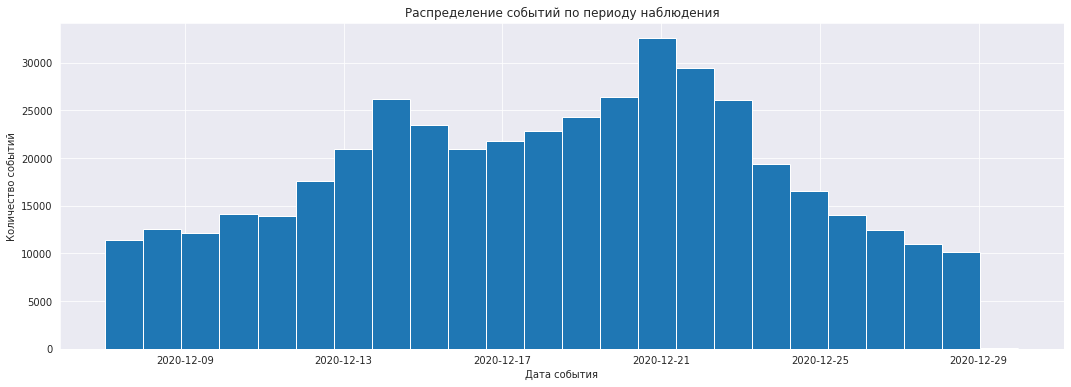

In [47]:
events['event_dt_date'].hist(bins = 24, figsize=(18, 6))

plt.title('Распределение событий по периоду наблюдения')
plt.xlabel('Дата события')
plt.ylabel('Количество событий');

В датафрейме нет пропусков по дням событий. В начале 20-х чисел, перед католическим Рождеством, - пиковое значение.

Посмотрим, были ли маркетинговые активности в период проведения теста.

In [48]:
marketing[(marketing['start_dt'] <= '2021-01-04') | (marketing['finish_dt'] >= '2020-12-07')]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Да, рождественско-новогодняя рекламная кампания в том числе и в Европе. Ее, как и праздничные распродажи, можно считать внешним фактором, который может влиять на результаты теста. Позже посмотрим, параллельно ли делались замеры по группам для снижения влияния внешних факторов. 

Объединим таблицы с участниками теста и событиями, отфильтровав по участникам теста.

In [49]:
events_new = pd.merge(events, participants, how='inner', on='user_id') #параметр inner, чтобы в итоговую выборку попали пользователи из participants,
                                                                       #о действиях которых есть информация 

events_new.head(3)

,user_id,event_dt,event_name,details,event_dt_date,group,ab_test
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,A,recommender_system_test
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,2020-12-09,A,recommender_system_test
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,2020-12-07,A,recommender_system_test


Дополнительно отфильтруем события по уникальным пользователям, которые соответствуют требованям ТЗ.

In [50]:
events_new = events_new.query('user_id in @test_participants')

In [51]:
if users['user_id'].nunique() == events_new['user_id'].nunique():
  print('Уникальных участников теста по-прежнему', events_new['user_id'].nunique(),'- никто не потерялся')
else:
  print('Кто-то потерялся. Количество уникальных участников после фильтрации не совпадает. Было -', users['user_id'].nunique(), 'Стало -',events_new['user_id'].nunique(),\
        'Изменения -', round(((events_new['user_id'].nunique() / users['user_id'].nunique() * 100) - 100), 2), '%')

Кто-то потерялся. Количество уникальных участников после фильтрации не совпадает. Было - 6351 Стало - 3481 Изменения - -45.19 %


Почти у половины отфильтрованных участников теста нет сведений по событиям. Рассмотри их подробнее.

In [52]:
users_without_events = pd.merge(events, participants, how='right', on='user_id') 

users_without_events = users_without_events[users_without_events['event_dt_date'].isna()]

users_without_events = pd.merge(users, users_without_events, how='inner', on='user_id')

users_without_events = users_without_events.groupby(['first_date', 'group'])['user_id'].nunique().reset_index()

users_without_events['first_date'] = users_without_events['first_date'].dt.strftime('%Y-%m-%d')

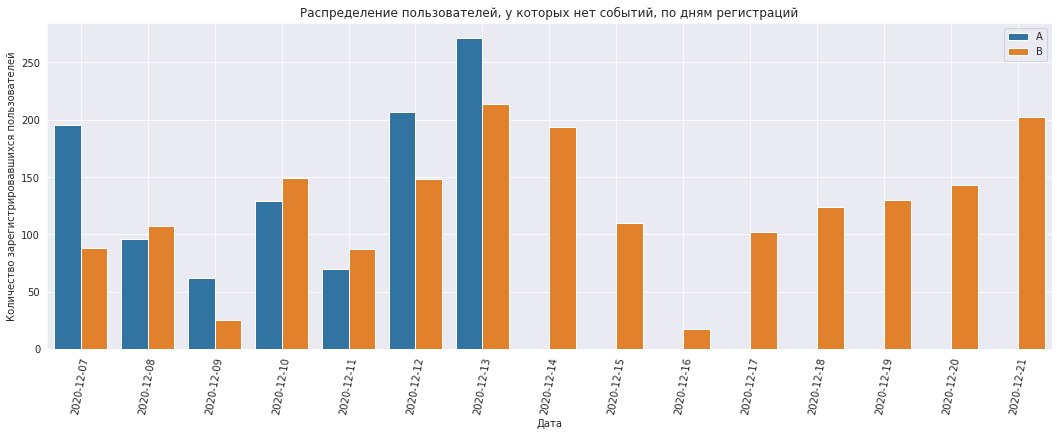

In [53]:
sns.set_style('dark')

plt.figure(figsize=(18, 6))

sns.barplot(x='first_date', y='user_id', data=users_without_events, hue='group')

plt.title('Распределение пользователей, у которых нет событий, по дням регистраций')
plt.xlabel('Дата')
plt.ylabel('Количество зарегистрировавшихся пользователей')
plt.legend(loc='upper right', fontsize=10)
plt.grid()
plt.xticks(rotation=80)
plt.show()

Обнаружили странность. Начиная с понедельника, 14 декабря, уникальные пользователи без событий попадали только в тестовую группу B, в тот время как в A с этого периода не оказалось ни одного. Возможно, кто-то внес изменения в настройки сбора сведений для теста, начиная с 14 декабря. Либо с этой даты возникла ошибка при загрузке сведений об уникальных пользователях без событий из контрольной группы.

Добавим даты регистрации в датафрейм с отфильтрованными данными.

In [54]:
events_new = pd.merge(users, events_new, how='inner', on='user_id') #параметр inner, чтобы в итоговую выборку попали пользователи из participants,
                                                                       #о действиях которых есть информация 

events_new.head(3)

,user_id,first_date,region,device,event_dt,event_name,details,event_dt_date,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:10,product_page,NaN,2020-12-07,A,recommender_system_test
1,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:07,login,NaN,2020-12-07,A,recommender_system_test
2,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-07 15:32:54,product_page,NaN,2020-12-07,B,recommender_system_test


По условиям ТЗ, анализируется 14-дневный срок с момента регистрации пользователей. Учтем это требование.

In [55]:
events_new['14_days_last'] = events_new['first_date']  + timedelta(days=14)

In [56]:
events_new = events_new[events_new['event_dt_date'] <= events_new['14_days_last']].copy()

Еще раз проверим пересекающихся пользователей в группах.

In [57]:
all_group = set(events_new.query('group == "A"')['user_id']) & set(events_new.query('group == "B"')['user_id']) 

f'Одинаковых пользователей для групп A и B: {len(all_group)}'

'Одинаковых пользователей для групп A и B: 0'

In [58]:
print('После фильтрации в нашем распоряжении', events_new['event_dt_date'].count(), 'событий, а именно:')

После фильтрации в нашем распоряжении 22828 событий, а именно:


In [59]:
events_new['group'].value_counts()

A    17977
B     4851
Name: group, dtype: int64

In [60]:
events_new['group'].value_counts(normalize=True)

A   0.79
B   0.21
Name: group, dtype: float64

Выборки сильно отличаются.

In [61]:
events_new.groupby(['group', 'event_name'])['event_dt_date'].count().reset_index()

,group,event_name,event_dt_date
0,A,login,7968
1,A,product_cart,2385
2,A,product_page,5125
3,A,purchase,2499
4,B,login,2345
5,B,product_cart,625
6,B,product_page,1257
7,B,purchase,624


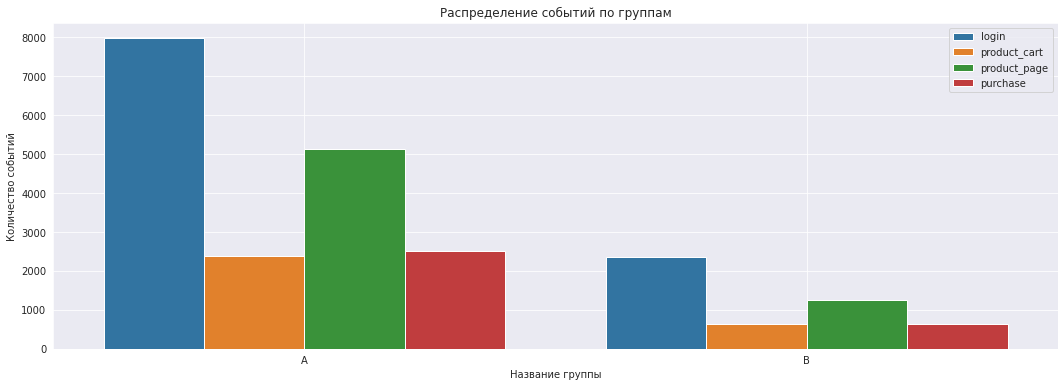

In [62]:
sns.set_style('dark')

plt.figure(figsize=(18, 6))

sns.barplot(x='group', y='event_dt_date', data=events_new.groupby(['group', 'event_name'])['event_dt_date'].count().reset_index(), hue='event_name')

plt.title('Распределение событий по группам')
plt.xlabel('Название группы')
plt.ylabel('Количество событий')
plt.legend(loc='upper right', fontsize=10)
plt.grid()

plt.show()

Количество сообытий по группам распределено пропорционально, хотя в группе В втрое меньше событий. 

Посмотрим, составили ли отфильтрованные участники теста 15% от всех клиентов в Европе, как было установлено в ТЗ.

In [63]:
test_participants = events_new['user_id'].tolist()

In [64]:
print('Доля отфильтрованных участников теста от общего числа клиентов из Европы -',\
      round(total_users.query('user_id in @test_participants')['region'].value_counts()[0] / total_users_by_regions[0] * 100, 2), '%')
print()
print('Согласно ТЗ, требуется 15%, не хватает',\
      round(15 - round(total_users.query('user_id in @test_participants')['region'].value_counts()[0] / total_users_by_regions[0] * 100, 2), 2), 'п.п.')


Доля отфильтрованных участников теста от общего числа клиентов из Европы - 7.52 %

Согласно ТЗ, требуется 15%, не хватает 7.48 п.п.


Таким образом, выводы на соответствие данным теста ТЗ:

ДА:
- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- отфильтровали 14 дней с момента регистрации.

НЕТ:
- Данные заканчиваются 2020-12-30, вместо 2021-01-04;
- аудитория новых пользователей из региона EU не равна заявленным 15%, по факту - вдвое меньше 
- ожидаемое количество участников теста: 6000.
- участников гораздо меньше заявленных 6000, но тех, у кого есть события - 3481.

У нас совсем мало дней наблюдений, чтобы набрать когорты посетителей и оценить изменения событий в этих когортах. С 7 по 24 декабря - 18 дней. С 25-го начинается рождественская промо-акция. Она пересекается с тестом формально 11 дней, а фактически, поскольку данные событий только до 30 декабря - 6.  


## Проведем исследовательский анализ данных

### Количество событий на пользователя одинаково распределены в выборках?


In [65]:
events_new.groupby('user_id').agg({'event_name': 'count'}).describe()

,event_name
count,"3,481.00"
mean,6.56
std,3.77
min,1.00
25%,4.00
50%,6.00
75%,9.00
max,24.00


На одного пользователя в среднем 7 событий. Медиана немного ниже - 6. Значит, выбросов не должно быть много.

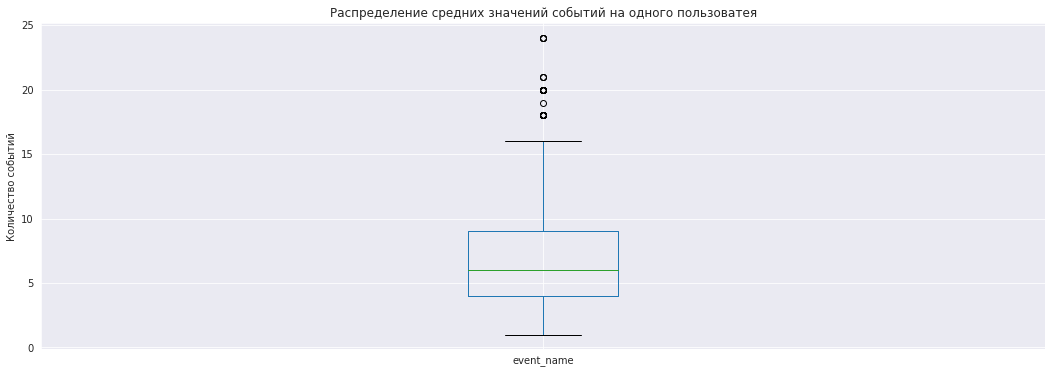

In [66]:
events_new.groupby('user_id').agg({'event_name': 'count'}).boxplot(figsize=(18, 6))

plt.title('Распределение средних значений событий на одного пользоватея')
plt.ylabel('Количество событий');

Выбросы есть, но их не мало.Вполне возможно, некоторые пользователи рьяно посещают сайт, изучают содержимое, но так ничего не покупают.

Посмотрим на события в выборках по дням.

In [67]:
distribution_by_days = events_new.groupby(['event_dt_date', 'group'])['event_name'].count().reset_index()
distribution_by_days['event_dt_date'] = distribution_by_days['event_dt_date'].dt.strftime('%Y-%m-%d')


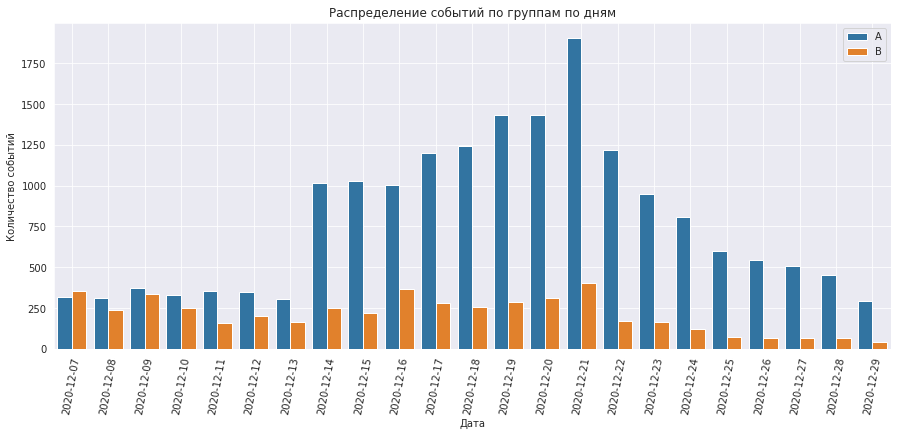

In [68]:
sns.set_style('dark')

plt.figure(figsize=(15, 6))

sns.barplot(x='event_dt_date', y='event_name', data=distribution_by_days, hue='group')

plt.title('Распределение событий по группам по дням')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.legend(loc='upper right', fontsize=10)
plt.grid()
plt.xticks(rotation=80)
plt.show()

В первый день выборка группы B даже немного выше. Со второй недели (с 7 декабря, в понедельник) у выборки А наблюдается четырехкратное количественное опережение выборки В. Показатели группы А растут всю вторую неделю. На начало третьей (21 декабря, снова понедельник) приходится пик обеих выборок. После 21 декабря у группы A явное снижение количества событий, у группы B - небольшое снижение. Отметим, что снижение приходится на начало рекламной кампании и период рождественско-новогодних праздников.

### Воронки событий

Определим, сколько пользователей совершали каждое из событий, а также долю пользователей, которые хоть раз совершали событие. Не забудем о последовательности действий в воронке, которую мы установили выше.

In [69]:
events_new_A = events_new.query('group == "A"')
events_new_B = events_new.query('group == "B"')


In [70]:
parts_users_per_event_part_A= (events_new_A
                               .groupby('event_name').agg(number_of_users = ('user_id', 'nunique'))
                               .reset_index()
                               .sort_values('number_of_users', ascending=False)
                               .assign(user_share = lambda x: x['number_of_users'] * 100 / events_new_A['user_id']
                                       .nunique())
                                       )

parts_users_per_event_part_A.reindex([0,2,1,3])


,event_name,number_of_users,user_share
0,login,2604,100.00
2,product_page,1685,64.71
1,product_cart,782,30.03
3,purchase,833,31.99


In [71]:
parts_users_per_event_part_B= (events_new_B
                               .groupby('event_name').agg(number_of_users = ('user_id', 'nunique'))
                               .reset_index()
                               .sort_values('number_of_users', ascending=False)
                               .assign(user_share = lambda x: x['number_of_users'] * 100 / events_new_B['user_id']
                                       .nunique())
                                       )

parts_users_per_event_part_B.reindex([0,2,1,3])

,event_name,number_of_users,user_share
0,login,876,99.89
2,product_page,493,56.21
1,product_cart,244,27.82
3,purchase,249,28.39


Судя по тому, что не все залогинились, покупать можно и через сторонние сайты.

Перейдем к построению воронки.

In [72]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Группа А',
    y = ["login", "product_page",\
         "product_cart", "purchase	"],
    x = [2604, 1685, 782, 833],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Группа B',
    orientation = "h",
    y = ["login", "product_page",\
         "product_cart", "purchase	"],
    x = [876, 493, 244, 249],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.update_layout(title="Воронка событий", width=1200, height=500)
fig.show()

Судя по воронкам, показатели группы A выглядят лучше. Клиентов в долях от первоначального количества теряется меньше. До этапа `product_page` доходит 65% от первоначального кличества, в группе B только 56%.

### Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

Сильная диспропорция в группах. Данные соответствуют ТЗ частично. Число клиентов вдвое меньше ожидаемого количества. Не о всех днях теста есть информация по действиям пользователей. Крайне неудачное время проведения. На тест могут оказывать влиянеи внешние факторы в виде рождественско-новогодней рекламной кампании, предпраздничных распродаж.

## Изучим результаты A/B-тестирования

Определим, сколько пользователей в каждой группе, добавим колонку с общим количеством пользователей в каждой из групп.

In [73]:
users_by_events = events_new\
.pivot_table(index=['group'], columns = ['event_name'], values = 'user_id', aggfunc = 'nunique').reset_index()

users_by_events = users_by_events[['group',	'login',	'product_page', 'product_cart',	'purchase']]

users_total = events_new.groupby('group')['user_id'].nunique()

users_by_events['users_total'] = users_by_events['group'].apply(lambda x: users_total.loc[x])
users_by_events = users_by_events.set_index('group')

users_by_events

event_name,login,product_page,product_cart,purchase,users_total
group,,,,,
A,2604,1685,782,833,2604
B,876,493,244,249,877


Используем Z-тест. Применяем именно его, так как мы сравниваем доли на каждом этапе от общего числа уникальных пользователей. Важно проверить количество уникальных пользователей, посетивших тот или иной этап. Это необходимо, чтобы понимать, что пользователь вообще заходил на ту или иную страницу.

Напомним формулу:

$$Z = \frac{(P_1-P_2)(π_1 - π_2)}{\sqrt{P(1-P)(1/n_1+1/n_2)}}\sim N(0, 1)$$

Величина Z — стандартная для критерия со стандартным нормальным распределением: со средним, равным нулю, и стандартным отклонением, равным единице. Это указано в правой части формулы после ～ знака, который говорит, что выражение распределено как N(0,1).

Для удобства напишем функцию.

In [74]:
def st_test(part0, part1, total0, total1, alpha):  
    p1 = part0 / total0 
    p2 = part1 / total1 
    p_combined = (part0 + part1) / (total0 + total1) 
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total0 + 1/total1))
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value
 

    H_0: Доля события выборки группы A = доле события группы В
    Н_а: Доля события выборки группы А ≠ доле события группы В
   
    alpha = 0.05

In [75]:
pd.options.display.max_colwidth = 150
AB_pivot = pd.DataFrame(columns=['Группа_1', 'Группа_2', 'Событие', 'p_alpha', 'p_value', 'Результат'])
 
result_options = ["Отвергаем нулевую гипотезу - между долями есть статзначимая разница",
                  "Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"]

group_1 = 'A'
current_row = users_by_events.loc[group_1]
group_2 = 'B'
for event_number in range(4):
    curr_event = users_by_events.columns[event_number]
    p_value_result = st_test(current_row[curr_event], 
                                   users_by_events[curr_event][group_2],
                                   current_row['users_total'],
                                   users_by_events['users_total'][group_2],
                                   alpha = 0.05)    
    new_row = {'Группа_1': group_1,
               'Группа_2': group_2,
               'Событие': users_by_events.columns[event_number],
               'p_alpha': 0.05,
               'p_value': p_value_result,
               'Результат': result_options[int(p_value_result >= 0.05)]}
    AB_pivot = AB_pivot.append([new_row])
 
AB_pivot.index = range(len(AB_pivot))
AB_pivot              

,Группа_1,Группа_2,Событие,p_alpha,p_value,Результат
0,A,B,login,0.05,0.08,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
1,A,B,product_page,0.05,0.00,Отвергаем нулевую гипотезу - между долями есть статзначимая разница
2,A,B,product_cart,0.05,0.21,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
3,A,B,purchase,0.05,0.05,Отвергаем нулевую гипотезу - между долями есть статзначимая разница


Тест показал различие в конверсии между группами на этапе `product_page` и `purchase`. Откорректируем наши конечные p_value, использую поправку Холма-Шидака. Коррекция нужна, так как перед нами множественный непараметрический тест.

In [76]:
result_options = ["Отвергаем нулевую гипотезу - между долями есть статзначимая разница",
                  "Не получилось отвергнуть нулевую гипотезу, нет достаточных оснований считать доли разными"]
 
pvalues_corr_list = []  # откорректированные p-value
final_results = []  # итоговые результаты (отклоняем или нет)

for i in range(0, len(AB_pivot), 4):
    pvalues_list = AB_pivot.loc[i:i+3, 'p_value'].tolist()
    results, p_value_corr, _, _ = multi_correction.multipletests(pvalues_list, method='holm-sidak')
    pvalues_corr_list.extend([round(x, 5) for x in p_value_corr])
    final_results.extend([result_options[0] if x else result_options[1] for x in results])
 
AB_pivot = AB_pivot.drop('Результат', axis=1)
AB_pivot['p_value_corr'] = pvalues_corr_list
AB_pivot['Итоговый результат'] = final_results
 
AB_pivot

,Группа_1,Группа_2,Событие,p_alpha,p_value,p_value_corr,Итоговый результат
0,A,B,login,0.05,0.08,0.16,"Не получилось отвергнуть нулевую гипотезу, нет достаточных оснований считать доли разными"
1,A,B,product_page,0.05,0.00,0.00,Отвергаем нулевую гипотезу - между долями есть статзначимая разница
2,A,B,product_cart,0.05,0.21,0.21,"Не получилось отвергнуть нулевую гипотезу, нет достаточных оснований считать доли разными"
3,A,B,purchase,0.05,0.05,0.13,"Не получилось отвергнуть нулевую гипотезу, нет достаточных оснований считать доли разными"


Лишь на этапе `product_page` обнаружена статистически значимая разница в конверсиях.

## Выводы

Для проведения теста выбрано крайне неудачное время. Мощнейшие внешние факторы в виде новогодне-рождественских праздников, распродаж, промо-кампании, 11 дней которой пересекаются с датами проведения теста. Хотя по факту данных о событиях меньше - они заканчиваются не 4 января, когда останавливается тест, а 30 декабря. И то в этот день данные явно неполные.

Собранные данные соответствуют ТЗ лишь частично. Количество участников теста меньше заявленных 6000, аудитория сильно меньше планировавшихся 15% от новых пользователей из Европы. В выборках сильная диспропорция. Уникальных пользователей в тестовой группе - лишь 20%  от общего количества. 

Анализ воронки события показал, что конверсия в событиях контрольной группы A выглядит лучше. Клиентов в долях от первоначального количества теряется меньше. До этапа product_page доходит 65% от первоначального кличества, в группе B только 56%. Ни о каком улучшении метрик не менее, чем на 10%, и речи нет. 

Конверсия события `product_page` в тестовой группе B более чем на 13% ниже.

Конверсия события `product_cart` в тестовой группе B более чем на 7% ниже.

Конверсия события `purchase` в тестовой группе B более чем на 12% ниже.

Статтест не увидел статистически значимую разницу в конверсиях трех из четырех событий контрольной и тестовой групп. Лишь на этапе `product_page` обнаружена статистически значимая разница в конверсиях.

Таким образом, исследование показало, что внедрение улучшенной рекомендательной системы не достигло заявленных целей. Однако нельзя забывать про сильные внешние факторы, а также данные, которые лишь частично соответствовали ТЗ, плюс сомнения в адекватности данных вызывает тот факт, что, начиная с 14 декабря, в контрольную группу перестали попадать уникальные пользователи без событий.

Для более корректного исследования рекомендуем повторить тест и учесть недоcтатки, выявленные в ходе данного анализа.

